## **Proyek Akhir Machine Learning Terapan : Rekomendasi Sistem (Anime)**
**Nama: Masdarul Rizqi** <br>
**Email: m.rizqi1221@gmail.com** <br>
**ID Dicoding: masdarulrizqi** 
### **Memanggil Libray atau Modul**

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, zipfile

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from sklearn.metrics.pairwise import linear_kernel

In [2]:
local_zip = './zip/Anime Recommendations Database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./Data')
zip_ref.close()

## **Data Understanding**

In [3]:
directory = "./data"

data = {}

for file in os.listdir(directory):
    dataframe = os.path.splitext(file)[0]
    data[dataframe] = pd.read_csv(os.path.join(directory, file), delimiter=",") 

In [4]:
df_anime = data['anime']
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
df_rating = data['rating']
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
print(f"Mengecek dimension pada dataset anime : {df_anime.shape}")
print(f"Mengecek dimension pada dataset Rating : {df_rating.shape}")

Mengecek dimension pada dataset anime : (12294, 7)
Mengecek dimension pada dataset Rating : (7813737, 3)


## **Univariate Exploratory Data Analysis**

#### Anime Dataset
Attribute  | Keterangan
------------- | -------------
Anime_id | merepresentasikan Id unik untuk setiap anime
Name | merepresentasikan judul untuk setiap Anime
genre | merepresentasikan genre untuk setiap Anime
Type | merepresentasikan tipe untuk setiap Anime
Episodes | merepresentasikan jumlah episode untuk setiap Anime

#### Ratings Dataset

Attribute  | Keterangan
------------- | -------------
user_id | merepresentasikan Id unik untuk setiap penonton
anime_id | merepresentasikan Id unik untuk setiap anime    
rating | merepresentasikan penilaian yang diberikan oleh penonton


#### **Mengecek Tipe data**

In [7]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


### **Mengecek deskripsi**

In [9]:
df_anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [10]:
df_rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


### **Mengecek jumlah baris data dari setiap nilai unik**

In [11]:
print(f'Jumlah Anime : {len(df_anime.anime_id.value_counts())}')
print(f'Jumlah Penonton : {len(df_rating.user_id.value_counts())}')

Jumlah Anime : 12294
Jumlah Penonton : 73515


In [12]:
df_anime['genre'].value_counts()

genre
Hentai                                                  823
Comedy                                                  523
Music                                                   301
Kids                                                    199
Comedy, Slice of Life                                   179
                                                       ... 
Adventure, Drama, Fantasy, Game, Sci-Fi                   1
Adventure, Demons, Fantasy, Historical                    1
Action, Comedy, Drama, Mecha, Music, Sci-Fi, Shounen      1
Action, Comedy, Fantasy, Mecha, Sci-Fi, Shounen           1
Hentai, Slice of Life                                     1
Name: count, Length: 3264, dtype: int64

In [13]:
df_rating['rating'].value_counts().sort_index(ascending=False)

rating
 10     955715
 9     1254096
 8     1646019
 7     1375287
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
-1     1476496
Name: count, dtype: int64

In [14]:
anime_stat = df_rating.groupby('anime_id').agg({'rating': 'sum', 'user_id': 'count'}).reset_index()
anime_stat.columns = ['anime_id', 'rating', 'num_users']
result_df = pd.merge(df_anime, anime_stat, on='anime_id')
result_df = result_df.sort_values(by='rating_y', ascending=False)
top_rated_anime = result_df.head(10)
print(top_rated_anime[['name', 'rating_y', 'num_users']])

                                   name  rating_y  num_users
39                           Death Note    297260      39340
82                   Shingeki no Kyojin    216380      29584
19      Code Geass: Hangyaku no Lelouch    211800      27718
787                    Sword Art Online    209896      30583
154                        Angel Beats!    197856      27183
1      Fullmetal Alchemist: Brotherhood    197303      24574
13   Code Geass: Hangyaku no Lelouch R2    188262      24242
743                          Elfen Lied    185762      27506
194                 Fullmetal Alchemist    176627      25032
127                           Toradora!    175686      24283


In [15]:
anime_stat = df_rating.groupby('anime_id').agg({'rating': 'sum', 'user_id': 'count'}).reset_index()
anime_stat.columns = ['anime_id', 'rating', 'num_users']
result_df = pd.merge(df_anime, anime_stat, on='anime_id')
result_df = result_df.sort_values(by='rating_x', ascending=False)
top_rated_anime = result_df.head(10)
print(top_rated_anime[['name', 'rating_x', 'num_users']])

                                                   name  rating_x  num_users
9084                                   Mogura no Motoro      9.50          1
0                                        Kimi no Na wa.      9.37       2199
1                      Fullmetal Alchemist: Brotherhood      9.26      24574
9981                    Yakusoku: Africa Mizu to Midori      9.25          1
2                                              Gintama°      9.25       1386
3                                           Steins;Gate      9.17      19283
4                                         Gintama&#039;      9.16       3673
5     Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...      9.15       1233
6                                Hunter x Hunter (2011)      9.13       8575
9                              Gintama&#039;: Enchousen      9.11       2537


In [16]:
genre_stats = pd.merge(df_anime, anime_stat, on='anime_id')
genre_stats = genre_stats.assign(genre=result_df['genre'].str.split('|')).explode('genre')

genre_stats = genre_stats.groupby('genre').agg({'rating_y': 'mean', 'num_users': 'sum'}).reset_index()
top_genre_ratings = genre_stats.sort_values(by='rating_y', ascending=False)
top_genre_ratings[['genre', 'rating_y', 'num_users']]

,genre,rating_y,num_users
1028,"Action, Mecha, Military, School, Sci-Fi, Super...",211800.0,27718
418,"Action, Comedy, Drama, School, Supernatural",197856.0,27183
158,"Action, Adventure, Drama, Fantasy, Magic, Mili...",197303.0,24574
758,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",188262.0,24242
739,"Action, Drama, Horror, Psychological, Romance,...",185762.0,27506
...,...,...,...
1782,"Comedy, Ecchi, Fantasy, Game",-2.0,2
70,"Action, Adventure, Comedy, Fantasy, Mecha, Sci-Fi",-2.0,2
1306,"Adventure, Comedy, Josei, Slice of Life",-3.0,3
2657,"Drama, Shounen",-3.0,3


In [17]:
genre_stats = pd.merge(df_anime, anime_stat, on='anime_id')
genre_stats = genre_stats.assign(genre=result_df['genre'].str.split('|')).explode('genre')

genre_stats = genre_stats.groupby('genre').agg({'rating_x': 'mean', 'num_users': 'sum'}).reset_index()
top_genre_ratings = genre_stats.sort_values(by='rating_x', ascending=False)
top_genre_ratings[['genre', 'rating_x', 'num_users']]

,genre,rating_x,num_users
158,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.260,24574
2422,"Drama, Fantasy, Romance, Slice of Life, Supern...",9.060,17854
2634,"Drama, School, Shounen",9.050,44
758,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",8.980,24242
1464,"Adventure, Drama, Supernatural",8.930,22974
...,...,...,...
2918,"Horror, Sci-Fi",3.355,1179
684,"Action, Demons, Seinen, Super Power",3.320,60
2932,"Kids, Mecha",3.260,1
350,"Action, Adventure, Sci-Fi, Space, Super Power",3.250,1


## **Visualisasi Data**

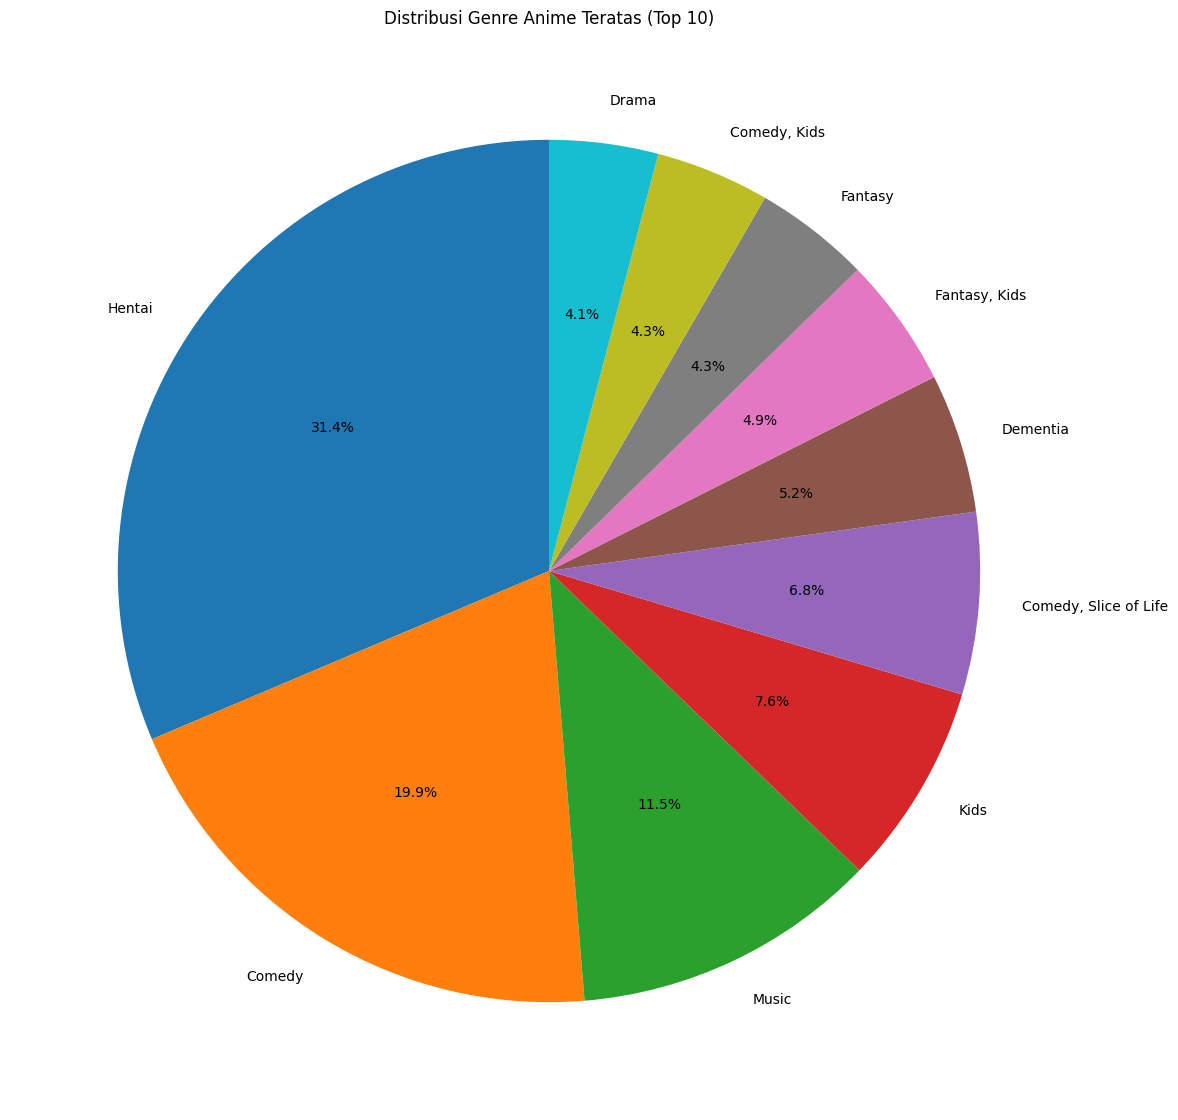

In [18]:
plt.figure(figsize=(14, 14))

value_counts = df_anime['genre'].value_counts().head(10)
value_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)

plt.title('Distribusi Genre Anime Teratas (Top 10)')
plt.ylabel('')

plt.show()

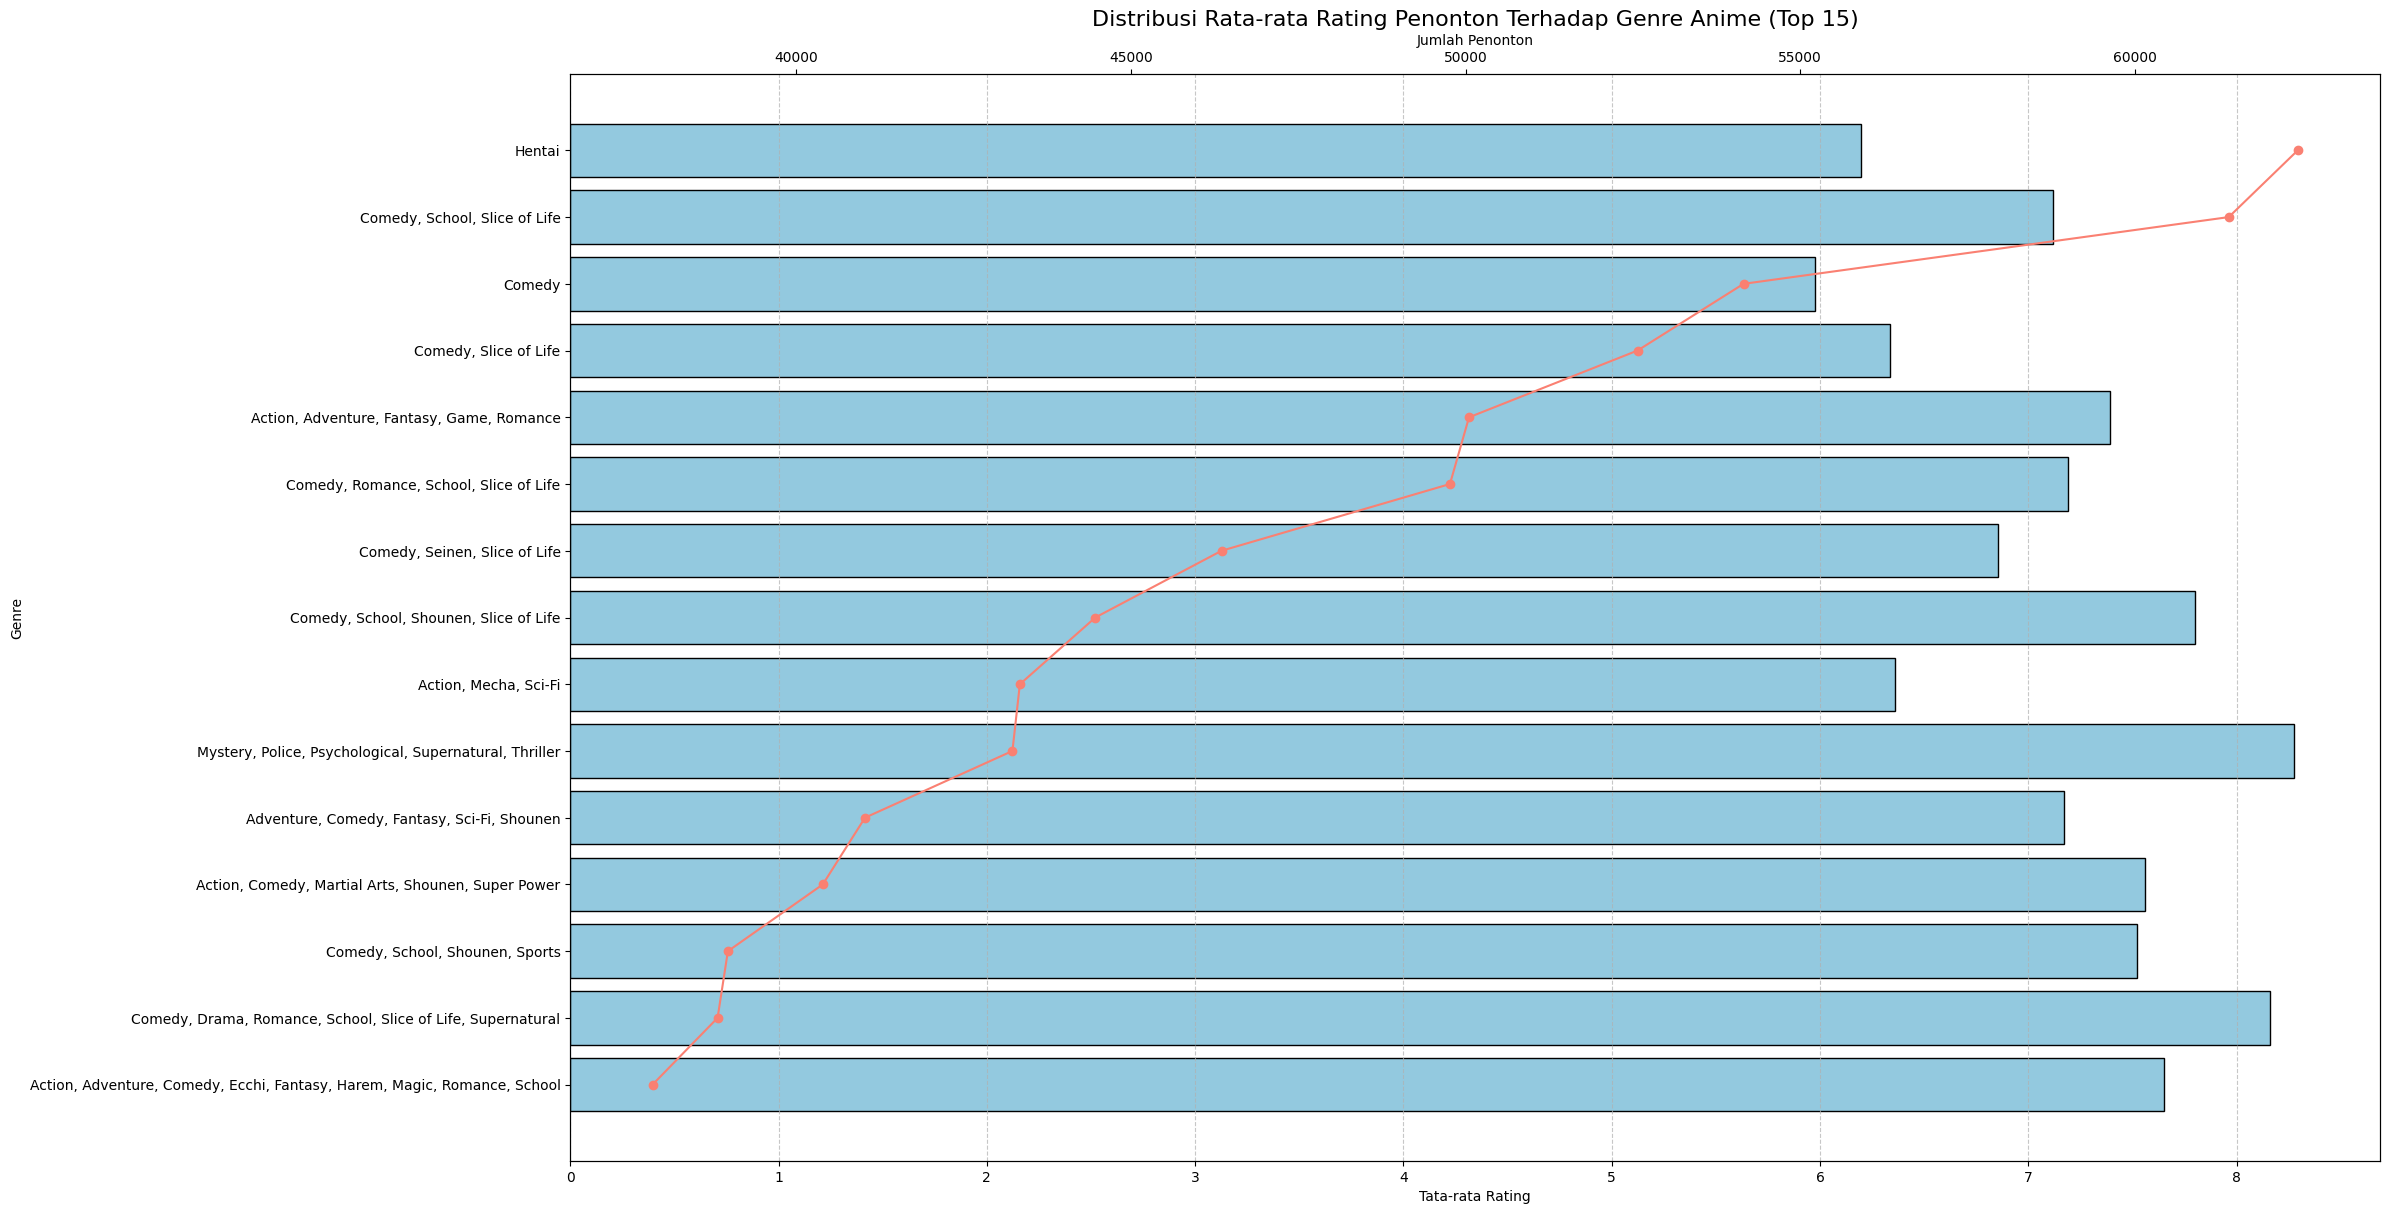

In [19]:
top_genre_ratings_sorted = top_genre_ratings.sort_values(by='num_users', ascending=False)
top_15_genres = top_genre_ratings_sorted.head(15)
fig, ax1 = plt.subplots(figsize=(24, 12))

ax1.set_xlabel('Tata-rata Rating')
ax1.set_ylabel('Genre')
sns.barplot(x='rating_x', y='genre', data=top_15_genres, color='skyblue', ax=ax1, edgecolor='black')
ax1.tick_params(axis='x')

ax2 = ax1.twiny()
color = 'salmon'
ax2.set_xlabel('Jumlah Penonton', color='black')
ax2.plot(top_15_genres['num_users'], top_15_genres['genre'], color=color, marker='o')
ax2.tick_params(axis='x', labelcolor='black')

plt.yticks(fontsize=12)

ax1.grid(axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.title('Distribusi Rata-rata Rating Penonton Terhadap Genre Anime (Top 15)', fontsize=16)
plt.show()

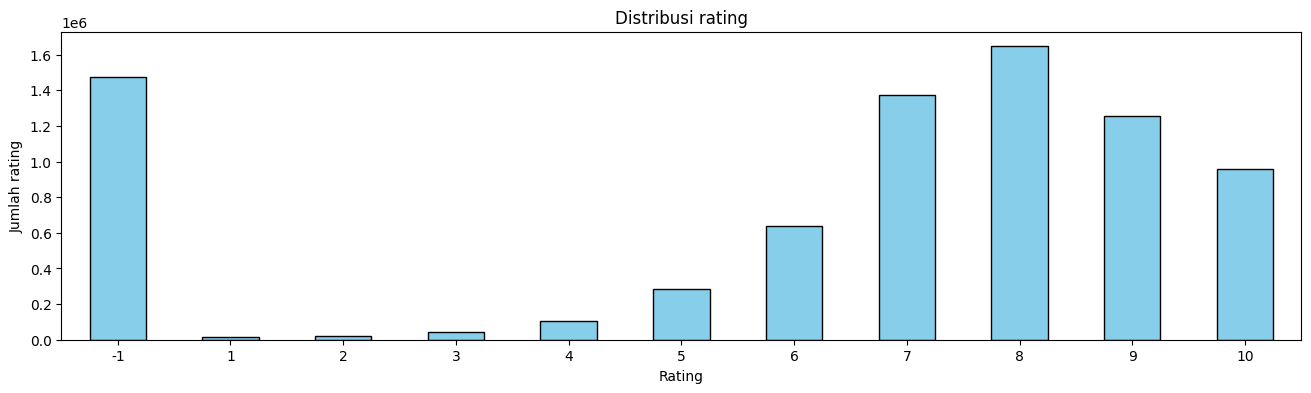

In [20]:
plt.figure(figsize=(16, 4))
rating = df_rating['rating'].value_counts().sort_index().index
df_rating['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribusi rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah rating')
plt.xticks(rotation=0)
plt.show()

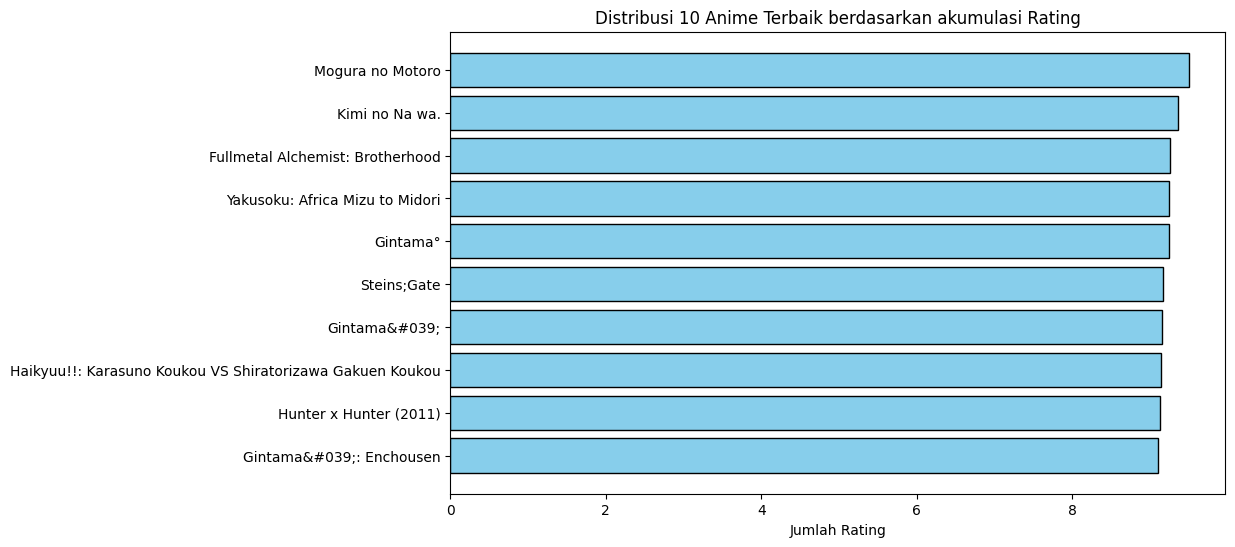

In [21]:
plt.figure(figsize=(10, 6))
plt.barh(top_rated_anime['name'], top_rated_anime['rating_x'], color='skyblue', edgecolor='black')
plt.xlabel('Jumlah Rating')
plt.title('Distribusi 10 Anime Terbaik berdasarkan akumulasi Rating')
plt.gca().invert_yaxis()
plt.show()

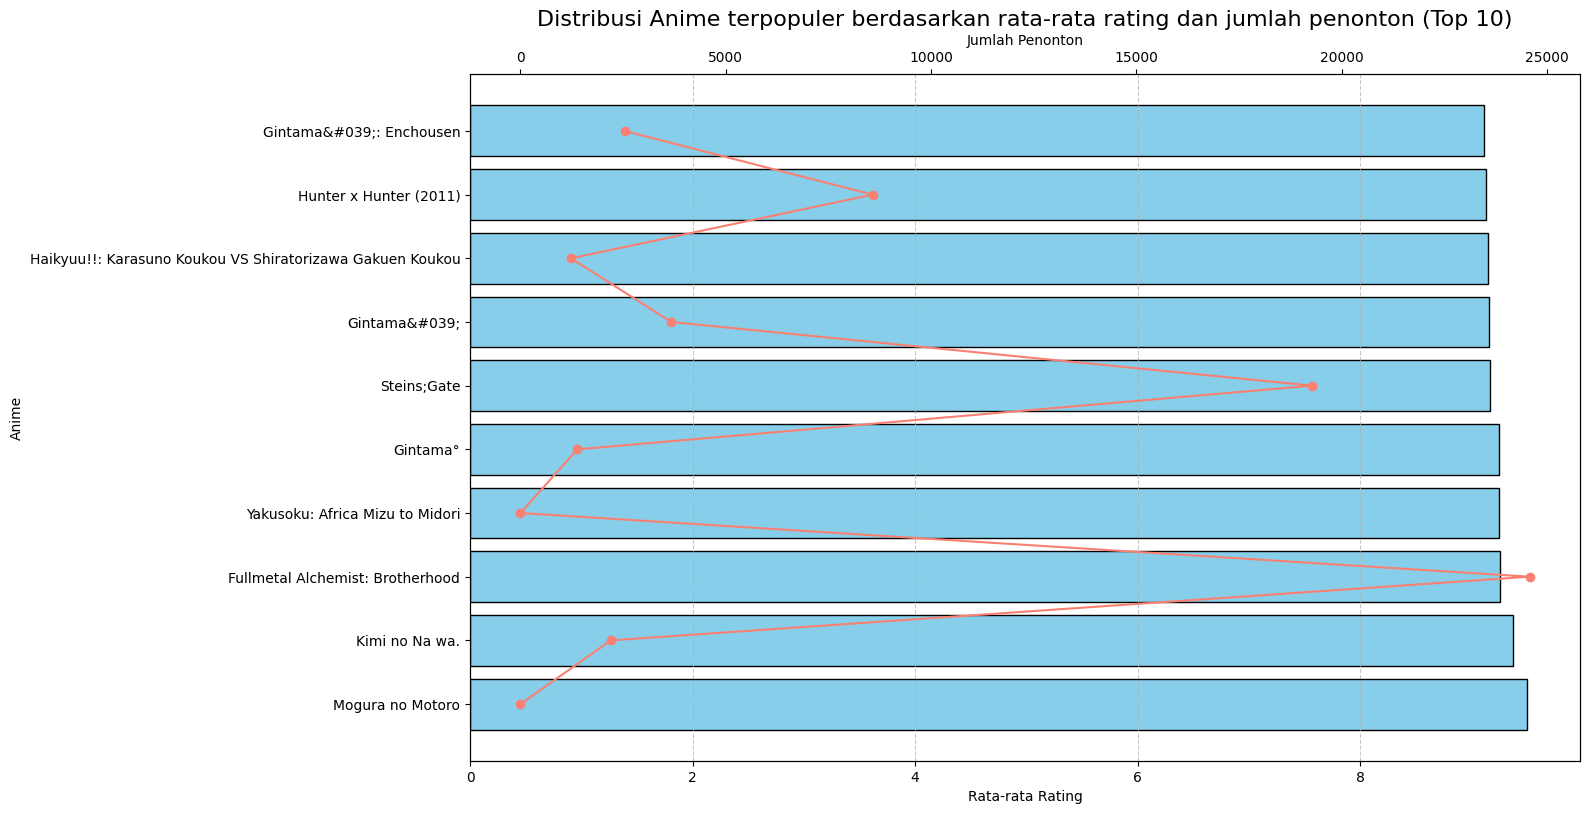

In [22]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'skyblue'
ax1.set_xlabel('Rata-rata Rating')
ax1.set_ylabel('Anime')
ax1.barh(top_rated_anime['name'], top_rated_anime['rating_x'], color=color, edgecolor='black')
ax1.tick_params(axis='x')

ax2 = ax1.twiny()
color = 'salmon' 
ax2.set_xlabel('Jumlah Penonton', color='black')
ax2.plot(top_rated_anime['num_users'], top_rated_anime['name'], color=color, marker='o')
ax2.tick_params(axis='x', labelcolor='black')

plt.yticks(fontsize=12)

ax1.grid(axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.title('Distribusi Anime terpopuler berdasarkan rata-rata rating dan jumlah penonton (Top 10)', fontsize=16)
plt.show()

## **Data Preprocessing**
#### **Anime Dataset**

In [23]:
df_anime[df_anime['name'].duplicated()]

,anime_id,name,genre,type,episodes,rating,members
10141,30059,Saru Kani Gassen,Drama,Movie,1,4.75,76
10194,33195,Shi Wan Ge Leng Xiaohua,"Action, Adventure, Comedy, Fantasy, Parody",Movie,1,7.07,110


In [24]:
df_anime[df_anime['name'] == "Shi Wan Ge Leng Xiaohuan"]

,anime_id,name,genre,type,episodes,rating,members


In [25]:
df_anime[df_anime['name'] == "Saru Kani Gassen"]

,anime_id,name,genre,type,episodes,rating,members
10140,22399,Saru Kani Gassen,Kids,OVA,1,5.23,62
10141,30059,Saru Kani Gassen,Drama,Movie,1,4.75,76


In [26]:
df_anime['name'].isnull().sum()

0

#### Rating dataset

In [27]:
df_rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

## **Model Development dengan Content Based Filtering**

In [28]:
anime_data = df_anime
anime_data.sample(5)

,anime_id,name,genre,type,episodes,rating,members
8451,15957,Dokachin,"Comedy, Kids",TV,26,5.62,84
6376,2754,Cleopatra D.C.,"Action, Adventure, Sci-Fi",OVA,3,6.14,1074
3559,83,Mobile Suit Gundam: The 08th MS Team - Miller&...,"Drama, Mecha, Military, Romance, Sci-Fi",Movie,1,6.95,8078
8710,16027,Greek Roman Sinhwa: Olympus Guardian,"Adventure, Fantasy, Historical",TV,39,6.57,275
1631,2927,Kimikiss Pure Rouge,"Drama, Romance, School",TV,24,7.48,58211


In [29]:
anime_data = anime_data.dropna(subset=['genre'])
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(anime_data['genre'])
feature_names = pd.DataFrame(tfidf_vectorizer.get_feature_names_out(), columns=['genre'])

In [30]:
anime_data['genre'].fillna('Unknown', inplace=True)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(anime_data['genre'])
feature_names = pd.DataFrame(tfidf_vectorizer.get_feature_names_out(), columns=['genre'])
feature_names

C:\Users\DELL\AppData\Local\Temp\ipykernel_7676\3673261513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_data['genre'].fillna('Unknown', inplace=True)


,genre
0,action
1,adventure
2,ai
3,arts
4,cars
5,comedy
6,dementia
7,demons
8,drama
9,ecchi


In [31]:
tfidf_matrix.shape 

(12232, 47)

#### **Mengubah matrix menjadi dense**

In [32]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29450574, 0.31749916, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.25046406, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [33]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=anime_data.name
).sample(24, axis=1).sample(5, axis=0)

,power,sports,martial,life,school,seinen,military,harem,supernatural,fi,...,adventure,game,shoujo,police,of,mystery,hentai,samurai,cars,slice
name,,,,,,,,,,,,,,,,,,,,,
Sugai-kun to Kazoku Ishi The Movie,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Paizuri Cheerleader vs. Sakunyuu Ouendan!,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000
Fushigi na Kusuri,0.0,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.577350
Noobow,0.0,0.0,0.0,0.510336,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.510336,0.0,0.0,0.0,0.0,0.510336
Bobby ni Kubittake,0.0,0.0,0.0,0.465643,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.465643,0.0,0.0,0.0,0.0,0.465643


#### **Menghitung Derajat Kesamaan (Cosine Similarity)**

In [34]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.14778251, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14778251, 1.        , 0.17849957, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17849957, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [35]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime_data['name'], columns=anime_data['name'])
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

name,Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival,Giga Tribe,Shigeru,Hajime no Ippo: Champion Road,One Piece: Oounabara ni Hirake! Dekkai Dekkai Chichi no Yume!
name,,,,,
Fate/kaleid liner Prisma☆Illya 2wei! Specials,0.182359,0.073502,0.114427,0.112025,0.207197
"Ore-tachi, Tomodachi!",0.186685,0.000000,0.000000,0.000000,0.212113
Metal Fight Beyblade vs. Taiyou: Shakunetsu no Shinryakusha Sol Blaze,0.417504,0.088923,0.138435,0.727400,0.248637
Yumeria,0.114868,0.533639,0.079851,0.078175,0.609938
Sister Princess: Re Pure Character&#039;s,0.000000,0.000000,0.000000,0.000000,0.000000
Duel Masters Cross,0.387782,0.298464,0.144521,0.454893,0.607897
Kodai Ouja Kyouryuu King,0.156038,0.000000,0.000000,0.000000,0.352363
Joshikousei: Girl&#039;s High Specials,0.067782,0.077483,0.120626,0.118093,0.077014
Perfect Day,0.000000,0.000000,0.000000,0.000000,0.000000


In [36]:
cosine_sim_df.shape

(12232, 12232)

## **Hasil Rekomendasi film berdasarkan genre**

In [37]:
def anime_recommendations(name, similarity_data=cosine_sim_df, items=anime_data[['name', 'genre']], k=5):

    index = similarity_data.loc[:, name].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]].drop(name, errors='ignore')
    recommendations = pd.DataFrame(closest).merge(items).head(k)
    
    return recommendations

anime_data[anime_data.name.eq('One Piece')]

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862


In [38]:
anime_recommendations('One Piece')

,name,genre
0,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
1,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
2,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
3,One Piece: Episode of Luffy - Hand Island no B...,"Action, Adventure, Comedy, Fantasy, Shounen, S..."
4,One Piece Recap,"Action, Adventure, Comedy, Fantasy, Shounen, S..."


## **Model Development dengan Collaborative Filtering**

In [39]:
rating_data = df_rating
user_to_user_encoded = {user_id: i for i, user_id in enumerate(rating_data['user_id'].unique())}
user_encoded_to_user = {i: user_id for i, user_id in enumerate(rating_data['user_id'].unique())}

anime_to_anime_encoded = {anime_id: i for i, anime_id in enumerate(rating_data['anime_id'].unique())}
anime_encoded_to_anime = {i: anime_id for i, anime_id in enumerate(rating_data['anime_id'].unique())}

rating_data['User'] = rating_data['user_id'].map(user_to_user_encoded)
rating_data['Anime'] = rating_data['anime_id'].map(anime_to_anime_encoded)

num_users = len(user_to_user_encoded)
num_movies = len(anime_encoded_to_anime)
min_rating = rating_data['rating'].min()
max_rating = rating_data['rating'].max()

value = pd.DataFrame({'Value Count': [num_users, num_movies, min_rating, max_rating]},
                     index=['Number of User', 'Number of Movie', 'Min Rating', 'Max Rating'])

value

,Value Count
Number of User,73515
Number of Movie,11200
Min Rating,-1
Max Rating,10


#### **Membagi Data untuk Training dan Validasi**

In [40]:
rating_data = rating_data.sample(frac=1, random_state=42)
rating_data.sample(5)

,user_id,anime_id,rating,User,Anime
1022181,9720,11111,9,9719,194
5698943,53465,2170,8,53463,3515
7539064,70586,1808,8,70584,2310
5939546,55475,299,8,55473,2422
2859705,26731,25099,6,26730,136


In [41]:
x = rating_data[['User', 'Anime']].values
y = (rating_data['rating'] - min_rating) / (max_rating - min_rating)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(x, y)

[[73422  1067]
 [59787   256]
 [55958   603]
 ...
 [59481  3659]
 [65005    22]
 [59404     0]] 7806172    1.000000
6470262    0.636364
5975474    1.000000
7617688    1.000000
5932334    0.818182
             ...   
6550634    0.727273
7705870    0.000000
6423388    0.818182
6962611    0.727273
6413414    0.818182
Name: rating, Length: 7813737, dtype: float64


#### **Proses Training**

In [42]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_anime, embedding_size, dropout_rate=0.2, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_anime = num_anime
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_embedding_dropout = layers.Dropout(dropout_rate)
        self.user_bias = layers.Embedding(num_users, 1)

        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.anime_embedding_dropout = layers.Dropout(dropout_rate)
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_vector = self.user_embedding_dropout(user_vector)
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_vector = self.anime_embedding_dropout(anime_vector)
        anime_bias = self.anime_bias(inputs[:, 1])

        dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)
        x = dot_user_anime + user_bias + anime_bias

        return tf.nn.sigmoid(x)

In [43]:
model = RecommenderNet(num_users, num_movies, 50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=25,  
    validation_data=(x_val, y_val)
)



Epoch 1/25

24418/24418 [==============================] - 984s 40ms/step - loss: 0.6963 - root_mean_squared_error: 0.3419 - val_loss: 0.6952 - val_root_mean_squared_error: 0.3271
Epoch 2/25
24418/24418 [==============================] - 986s 40ms/step - loss: 0.8223 - root_mean_squared_error: 0.3643 - val_loss: 0.7368 - val_root_mean_squared_error: 0.3267
Epoch 3/25
24418/24418 [==============================] - 971s 40ms/step - loss: 0.8490 - root_mean_squared_error: 0.3607 - val_loss: 0.7262 - val_root_mean_squared_error: 0.3098
Epoch 4/25
24418/24418 [==============================] - 977s 40ms/step - loss: 0.8192 - root_mean_squared_error: 0.3454 - val_loss: 0.7016 - val_root_mean_squared_error: 0.2951
Epoch 5/25
24418/24418 [==============================] - 991s 41ms/step - loss: 0.7785 - root_mean_squared_error: 0.3310 - val_loss: 0.6820 - val_root_mean_squared_error: 0.2823
Epoch 6/25
24418/24418 [==============================] - 971s 40ms/step - loss: 0.7331 - root_mean_squ

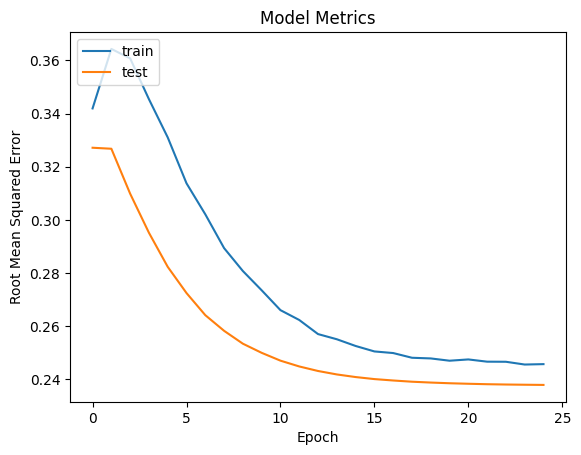

In [44]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### **Mendapatkan Rekomendasi Anime**

In [45]:
anime = anime_data

# Mengambil sample user
user_id = rating_data.user_id.sample(1).iloc[0]
anime_watched_by_user = rating_data[rating_data.user_id == user_id]
 
anime_not_watched = anime[~anime['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id']
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)


In [46]:
rating = model.predict(user_anime_array).flatten()

top_rating_indices = rating.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_rating_indices
]
# Showing Recommendations for Users
print('Showing Recommendations for User: {}'.format(user_id))
print('===' * 9)

# anime with High Rating from User
print('anime with High Rating from User')
print('----' * 8)

top_anime_user = (
    anime_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

anime_df_rows_user = anime[anime['anime_id'].isin(top_anime_user)]
for row in anime_df_rows_user.itertuples():
    print(row.name, ':', row.genre)

print('----' * 8)

# Top 10 anime Recommendation
print('Top 10 anime Recommendations')
print('----' * 8)

recommended_anime = anime[anime['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

342/342 [==============================] - 1s 1ms/step
Showing Recommendations for User: 46192
anime with High Rating from User
--------------------------------
Fate/Zero 2nd Season : Action, Fantasy, Supernatural, Thriller
Death Note : Mystery, Police, Psychological, Supernatural, Thriller
Ghost in the Shell: Stand Alone Complex 2nd GIG : Action, Mecha, Military, Mystery, Police, Sci-Fi, Seinen
Evangelion: 2.0 You Can (Not) Advance : Action, Mecha, Sci-Fi
Ghost in the Shell: Stand Alone Complex : Action, Mecha, Military, Police, Sci-Fi, Seinen
--------------------------------
Top 10 anime Recommendations
--------------------------------
Hunter x Hunter (2011) : Action, Adventure, Shounen, Super Power
Ginga Eiyuu Densetsu : Drama, Military, Sci-Fi, Space
Gintama : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Mushishi : Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural
Tengen Toppa Gurren Lagann : Action, Adventure, Comedy, Mecha, Sci-Fi
Hotaru